# ML vs Statistical Approach for CLV

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime

#Statistical LTV
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

#ML Approach to LTV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [4]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (10,7) 

In [7]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [87]:
data = pd.read_excel('online_retail_II 3.xlsx')


In [88]:
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [8]:
from datetime import datetime

In [9]:
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format = 'mixed')

In [10]:
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

In [11]:
data.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,weekend,dayofweek
49157,493979,20724,RED SPOTTY CHARLOTTE BAG,6,2010-01-10 11:58:00,0.85,17323.0,United Kingdom,2010-01-10,11:58:00,11,True,6
504704,536544,85016,SET OF 6 VINTAGE NOTELETS KIT,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2010-12-01,14:32:00,14,False,2
248594,513419,22501,PICNIC BASKET WICKER LARGE,2,2010-06-24 12:37:00,9.95,14732.0,United Kingdom,2010-06-24,12:37:00,12,False,3
16910,490745,21308,LOUVRE VANITY MIRROR,1,2009-12-07 18:02:00,17.35,NaN,United Kingdom,2009-12-07,18:02:00,18,False,0
352275,523649,35958,FOLKART ZINC STAR CHRISTMAS DEC,12,2010-09-23 12:42:00,0.85,13264.0,United Kingdom,2010-09-23,12:42:00,12,False,3


373 days 00:00:00


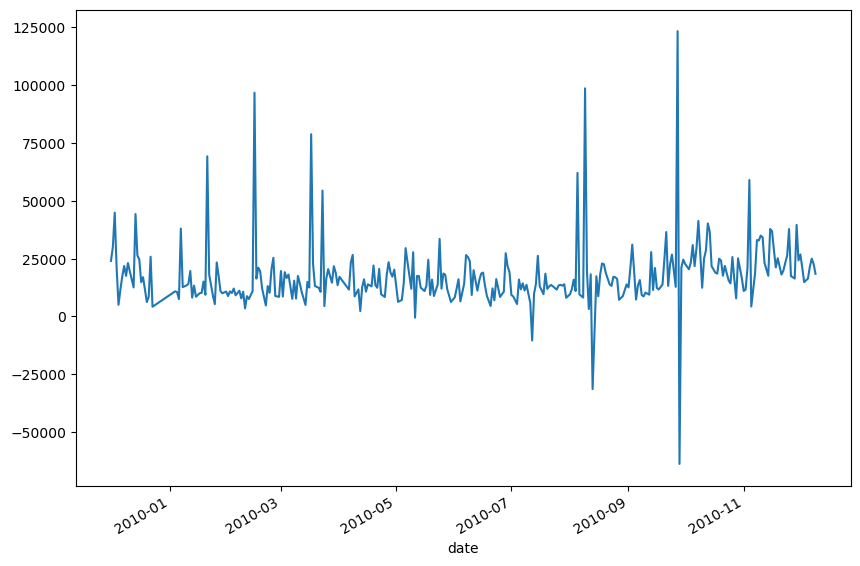

In [45]:
data.groupby('date')['Quantity'].sum().plot()
print(data['date'].max() - data['date'].min())

So, I have around 1 year of data. Because the ML approach requires time periods for feature creation, training targets, and validation targets, I'll split it into the following segments:
1. Training Features Period - from 2011-01-01 until 2011-06-11
2. Training Target Period - from 2011-06-12 until 2011-09-09
3. Testing Features Period - from 2011-04-02 until 2011-09-10
4. Testing Target Period - from 2011-09-11 until 2011-12-09

In [13]:
#Dataset info
print(f'Total Number of Purchases: {data.shape[0]}')
print(f'Total Number of transactions: {data.Invoice.nunique()}')
print(f'Total Unique Days: {data.date.nunique()}')
#print(f'Total Unique Customers: {data.Customer ID.nunique()}')
print(f"We are predicting {(data['date'].max() - datetime(2010, 9, 10)).days} days")

Total Number of Purchases: 525461
Total Number of transactions: 28816
Total Unique Days: 307
We are predicting 90 days


## Baseline: BG/NBD + Gamma-Gamma model

BG/NDB and Gamma-Gamma models are statistical models that model the purchasing behaviour (transactions and the average order value) by fitting different types of distributions. This type of modelling requires the data on transaction level, so let's first aggregate the dataset by the invoice. I'll be aggregating the transactional revenue which is simply calculated as the quantity times the item price.

### Data Prep

In [14]:
#Get revenue column
data['Revenue'] = data['Quantity'] * data['Price']

#Context data for the revenue (date & customerID)
id_lookup = data[['Customer ID', 'Invoice', 'date']].drop_duplicates()
id_lookup.index = id_lookup['Invoice']
id_lookup = id_lookup.drop('Invoice', axis=1)

transactions_data = pd.DataFrame(data.groupby('Invoice')['Revenue'].sum()).join(id_lookup)

In [15]:
transactions_data.head()

,Revenue,Customer ID,date
Invoice,,,
489434,505.30,13085.0,2009-12-01
489435,145.80,13085.0,2009-12-01
489436,630.33,13078.0,2009-12-01
489437,310.75,15362.0,2009-12-01
489438,2286.24,18102.0,2009-12-01


In [16]:
transactions_data['date'].unique()

<DatetimeArray>
['2009-12-01 00:00:00', '2009-12-02 00:00:00', '2009-12-03 00:00:00',
 '2009-12-04 00:00:00', '2009-12-05 00:00:00', '2009-12-06 00:00:00',
 '2009-12-07 00:00:00', '2009-12-08 00:00:00', '2009-12-09 00:00:00',
 '2009-12-10 00:00:00',
 ...
 '2010-11-29 00:00:00', '2010-11-30 00:00:00', '2010-12-01 00:00:00',
 '2010-12-02 00:00:00', '2010-12-03 00:00:00', '2010-12-05 00:00:00',
 '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
 '2010-12-09 00:00:00']
Length: 307, dtype: datetime64[ns]

In [17]:

# #predict revenue of only those that have purchased in the specified period for comparisonrelevant_ids = transactions_data.loc[(pd.to_datetime(transactions_data.date) >='2011-03-09') &(pd.to_datetime(transactions_data.date) <= '2011-09-10'), 'CustomerID'].unique()
# relevant_transations = transactions_data.loc[transactions_data['CustomerID'].isin(relevant_ids), :]

`lifetimes` package has a utility function to split the data and aggregate the features into RFM format. So here, I'm going to use it to save some time, but if the data is large, it makes sense to do this yourselve.

In [20]:
from  datetime import datetime

In [21]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data



In [22]:
2010, 9, 10

(2010, 9, 10)

In [23]:
#Spit into train - test
rfm_train_test = calibration_and_holdout_data(transactions_data, 'Customer ID', 'date',
                                        calibration_period_end='2010-09-09',
                                        monetary_value_col = 'Revenue')   

#Selecting only customers with positive value in the calibration period (otherwise Gamma-Gamma model doesn't work)
rfm_train_test = rfm_train_test.loc[rfm_train_test['monetary_value_cal'] > 0, :]

In [24]:
print(rfm_train_test.shape)
rfm_train_test.head()

(2028, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer ID,,,,,,,
12349.0,2.0,165.0,279.0,634.260,1.0,1402.620,91.0
12358.0,1.0,181.0,275.0,268.100,1.0,1021.080,91.0
12359.0,5.0,199.0,278.0,231.468,1.0,551.330,91.0
12360.0,2.0,92.0,199.0,311.020,2.0,405.395,91.0
12361.0,2.0,220.0,226.0,106.075,0.0,0.000,91.0


### Modelling

Now, we can use the RFM calibration data to train the models.

In [25]:
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2028 subjects, a: 0.01, alpha: 44.62, b: 0.16, r: 1.00>

To fit Gamma-Gamma model, we first need to make sure that the monetary value and frequency are not correlated as this is one of the basi assumptions of the model.

In [26]:
#Train Gamma-Gamma
rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.177126
frequency_cal,0.177126,1.000000


They are not, so we can continue with fitting

In [27]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])


<lifetimes.GammaGammaFitter: fitted with 2028 subjects, p: 1.29, q: 3.50, v: 654.18>

In [95]:
data["Total Amount"] = data["Quantity"]*data["Price"]

In [97]:
import lifetimes

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
#import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [98]:
summary = lifetimes.utils.summary_data_from_transaction_data(data, "Customer ID", "InvoiceDate", "Total Amount")

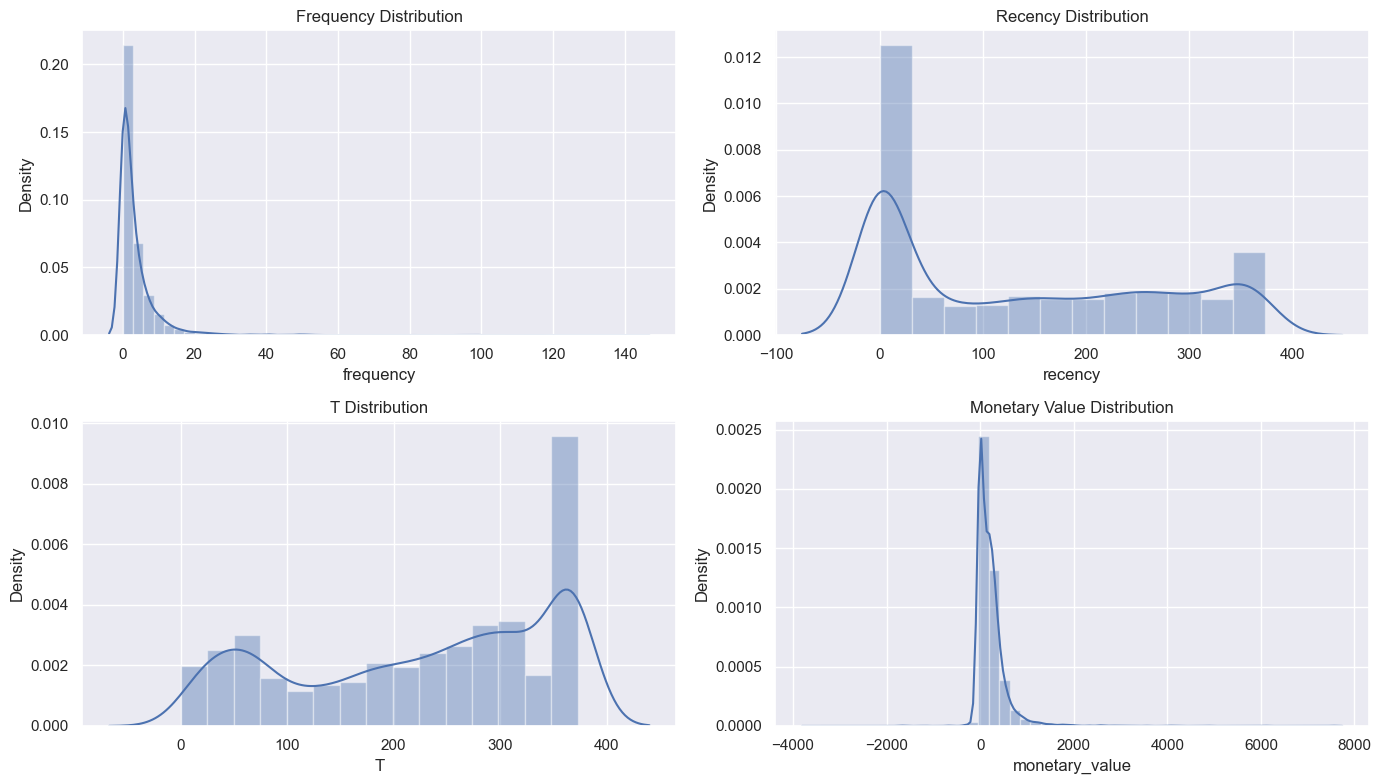

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution
plt.figure(figsize=(14, 8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")

plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")

plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")

plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")

plt.tight_layout()

# Save the plot as an image file
plt.savefig('distribution_plot.png')

plt.show()


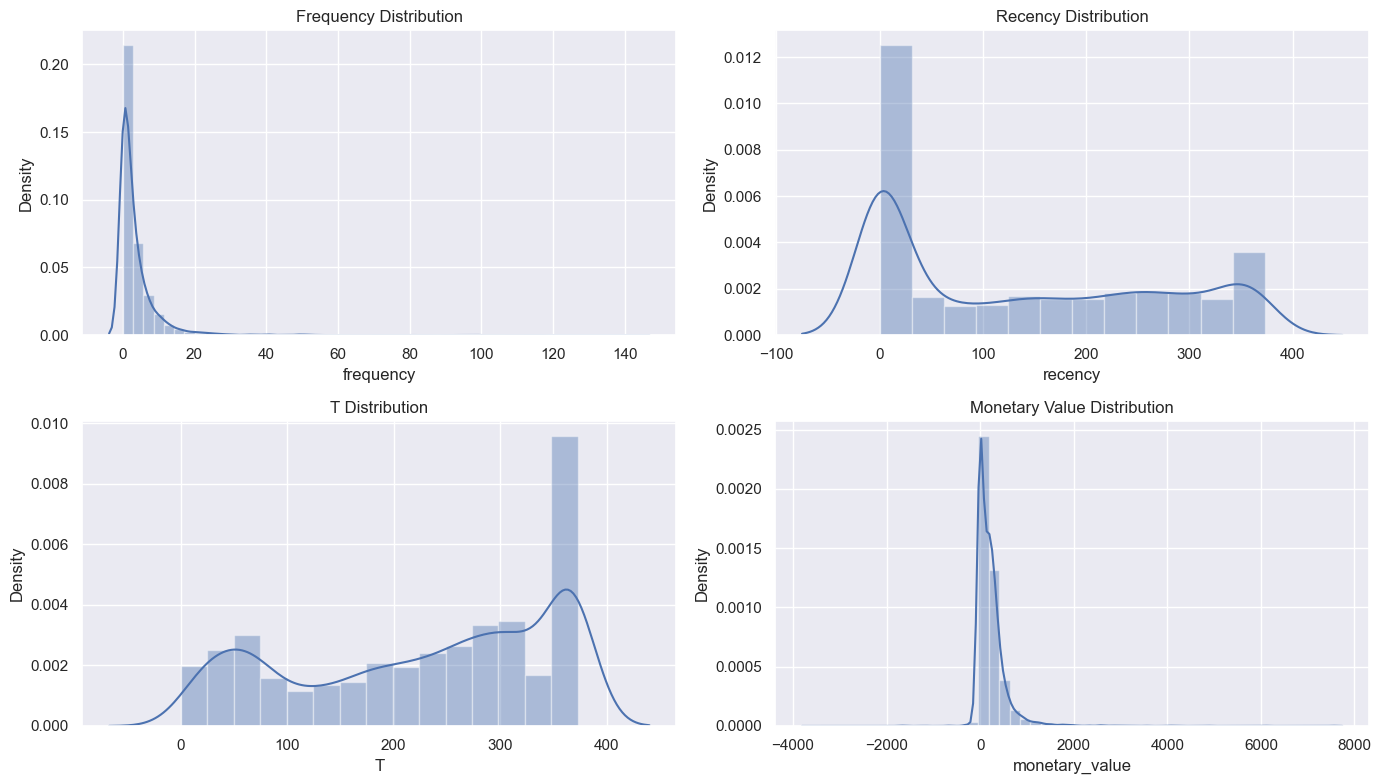

In [103]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()
plt.show()

In [108]:
plt.savefig('plot1.png')      

<Figure size 1000x700 with 0 Axes>

In [92]:
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive

### Prediction

Prediction is done in three steps:
1. Predict the expected number of transactions
2. Predict the average order value
3. Multiply number of transations by the average order value

In [28]:
#Predict the expected number of transactions in the next 89 days
predicted_bgf = bgf.predict(89,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])
trans_pred = predicted_bgf.fillna(0)

#Predict the average order value
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_cal'],
                                        rfm_train_test['monetary_value_cal'])

#Putting it all together
sales_pred = trans_pred * monetary_pred

In [29]:
sales_pred.max()

69204.51214993311

### Evaluation

In [46]:
actual = rfm_train_test['monetary_value_holdout'] *  rfm_train_test['frequency_holdout']

In [47]:
actual.max()

54928.21846153846

In [48]:
def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_pred.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_pred)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_pred)}")
    plt.scatter(sales_pred, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()
      

Total Sales Actual: 1678021.0
Total Sales Predicted: 1494295.0
Individual R2 score: 0.5938095593091752 
Individual Mean Absolute Error: 589.0473221037514


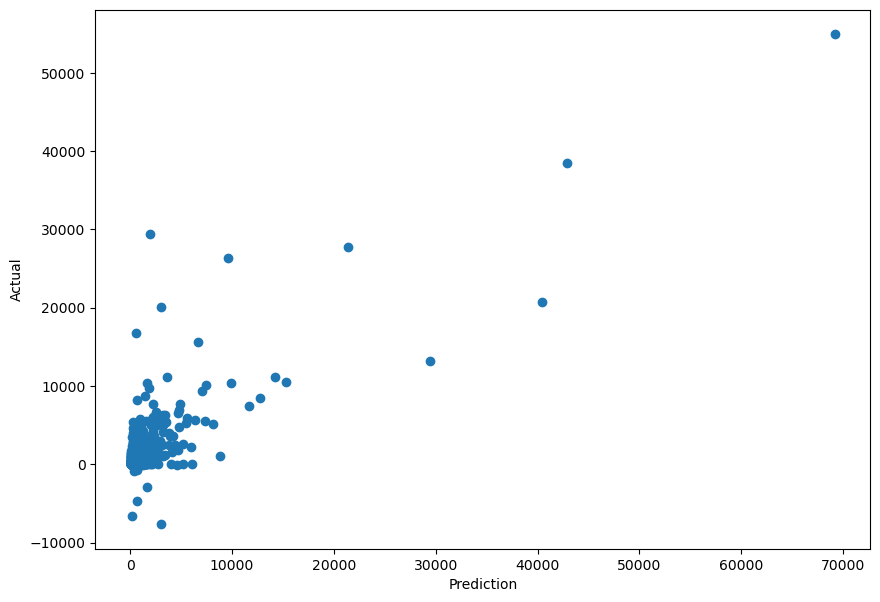

In [49]:
evaluate(actual, sales_pred)

## ML Approach

In [34]:
data.to_csv('new_use_data.csv', index=False)

In [ ]:
new = pd.read_csv("new_use_data.csv",index_col=False)

In [ ]:
new

In [50]:
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')
    
    #Transactions data features
    total_rev = features_data.groupby('Customer ID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('Customer ID')['date'].max() - features_data.groupby('Customer ID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('Customer ID')['Invoice'].count().rename('frequency')
    t = features_data.groupby('Customer ID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('Customer ID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('Customer ID')['Invoice'].count().rename('num_returns')
    hour = features_data.groupby('Customer ID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('Customer ID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('Customer ID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = rfm_train_test.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_data = train_data.fillna(0)
    
    #Target data
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['Customer ID'])['date'].nunique()
    target_rev = target_data.groupby(['Customer ID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)
    
    return train_data.iloc[:, :-1], train_data.iloc[:, -1]

In [36]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,time,hour,weekend,dayofweek,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,07:45:00,7,False,1,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,2010-12-09,20:01:00,20,False,3,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-09,20:01:00,20,False,3,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-09,20:01:00,20,False,3,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,2010-12-09,20:01:00,20,False,3,7.50


In [37]:
data['InvoiceDate'].value_counts().to_csv("new.csv")

In [38]:
data['Invoice']

0         489434
1         489434
2         489434
3         489434
4         489434
           ...  
525456    538171
525457    538171
525458    538171
525459    538171
525460    538171
Name: Invoice, Length: 525461, dtype: object

In [39]:
2010-03-07 15:34:00
2010-06-08 16:47:00
2010-11-07 16:29:00
2010-05-07 09:04:00

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3748459341.py, line 1)

In [40]:
['2009-12-01 00:00:00', '2009-12-02 00:00:00', '2009-12-03 00:00:00',
 '2009-12-04 00:00:00', '2009-12-05 00:00:00', '2009-12-06 00:00:00',
 '2009-12-07 00:00:00', '2009-12-08 00:00:00', '2009-12-09 00:00:00',
 '2009-12-10 00:00:00',
 ...
 '2010-11-29 00:00:00', '2010-11-30 00:00:00', '2010-12-01 00:00:00',
 '2010-12-02 00:00:00', '2010-12-03 00:00:00', '2010-12-05 00:00:00',
 '2010-12-06 00:00:00', '2010-12-07 00:00:00', '2010-12-08 00:00:00',
 '2010-12-09 00:00:00']

SyntaxError: invalid syntax. Perhaps you forgot a comma? (760969403.py, line 5)

In [51]:
X_train, y_train = get_features(data, '2010-09-01', '2011-02-9', '2011-02-10', '2011-05-10')

Using data from 161 days
To predict 89 days


In [52]:
X_test, y_test = get_features(data, '2010-10-01', '2011-03-11', '2011-03-12', '2011-06-10')

Using data from 161 days
To predict 90 days


### Modelling
Here, I'm going to use a Keras API to Tensorflow to build a simple DNN. Architecture here doesn't really matter because the problem is simple and small enough. However, if you have more data, make sure to fine tune the model. Start small, and see if the performance increases as the complexity increases.

In [77]:
#DNN
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse','rsquare'])
    
    return model

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [54]:
epochs = range(100)

In [85]:
%pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [55]:
import tensorflow_docs as tfdocs

In [67]:
model = build_model()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
class CustomEpochDots(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{epochs} - loss: {logs["loss"]:.4f} - val_loss: {logs["val_loss"]:.4f}')


In [63]:
callbacks = [early_stop, CustomEpochDots()]

In [65]:
callbacks = [early_stop, CustomEpochDots()]

In [73]:
early_history = model.fit(X_train, y_train, 
                          epochs=10, 
                          validation_split=0.2, 
                          verbose=0, 
                          callbacks=callbacks)

Epoch 1/range(0, 100) - loss: 260652.3281 - val_loss: 5300.2778
Epoch 2/range(0, 100) - loss: 150663.0469 - val_loss: 17243.1074
Epoch 3/range(0, 100) - loss: 87048.5703 - val_loss: 9707.7021
Epoch 4/range(0, 100) - loss: 244284.4531 - val_loss: 4014.6726
Epoch 5/range(0, 100) - loss: 58996.5703 - val_loss: 13530.3008
Epoch 6/range(0, 100) - loss: 61257.8398 - val_loss: 6032.8652
Epoch 7/range(0, 100) - loss: 57685.0898 - val_loss: 1899.0945
Epoch 8/range(0, 100) - loss: 36996.7070 - val_loss: 1092.6803
Epoch 9/range(0, 100) - loss: 14788.3721 - val_loss: 1609.5095
Epoch 10/range(0, 100) - loss: 17751.2188 - val_loss: 2467.7964


In [59]:
model

<Sequential name=sequential_1, built=True>

In [70]:
# using model checkpoint to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_DNN.keras',  # Path to save the model file with .keras extension
    monitor='val_loss',                 # Metric to monitor
    verbose=1,                          # Verbosity mode (0 or 1)
    save_best_only=True,                # Only save the best model
    mode='min',                         # Mode for the monitored metric
    save_weights_only=False,            # Whether to save only the model weights
    save_freq='epoch'                   # Save every epoch
)

In [78]:
early_history = model.fit(X_train, y_train, 
                    epochs=10, validation_split = 0.2, verbose=1)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 3969.8188 - mae: 18.6546 - mse: 3969.8188 - val_loss: 138.6297 - val_mae: 2.6824 - val_mse: 138.6297
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 5307.8013 - mae: 19.4750 - mse: 5307.8013 - val_loss: 299.8319 - val_mae: 2.9643 - val_mse: 299.8319
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 7151.1582 - mae: 19.1252 - mse: 7151.1582 - val_loss: 3674.4280 - val_mae: 11.3206 - val_mse: 3674.4280
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 13792.6787 - mae: 21.2127 - mse: 13792.6787 - val_loss: 18458.2793 - val_mae: 24.3627 - val_mse: 18458.2793
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 18737.4512 - mae: 23.2803 - mse: 18737.4512 - val_loss: 177.9149 - val_mae: 7.3227 - val_mse: 177.9149
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 5701.4243 - mae: 18.8758 - mse: 5701.4243 - val_loss: 492.6355 - val_mae: 10.1354 - val_mse: 492.6355
Epoch 7/10
51/51 ━━━━

In [75]:
early_history

## Evaluation

Let's see how well the model can predict the 3 next 3 months which it has never seen before. We're going to use data from the most recent period (X_test) to make sure that our forecast is as accurate as possible.

In [79]:
#Predicting
dnn_preds = model.predict(X_test).ravel()

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


Total Sales Actual: 0.0
Total Sales Predicted: 1494295.0
Individual R2 score: 0.0 
Individual Mean Absolute Error: 736.8320338955846


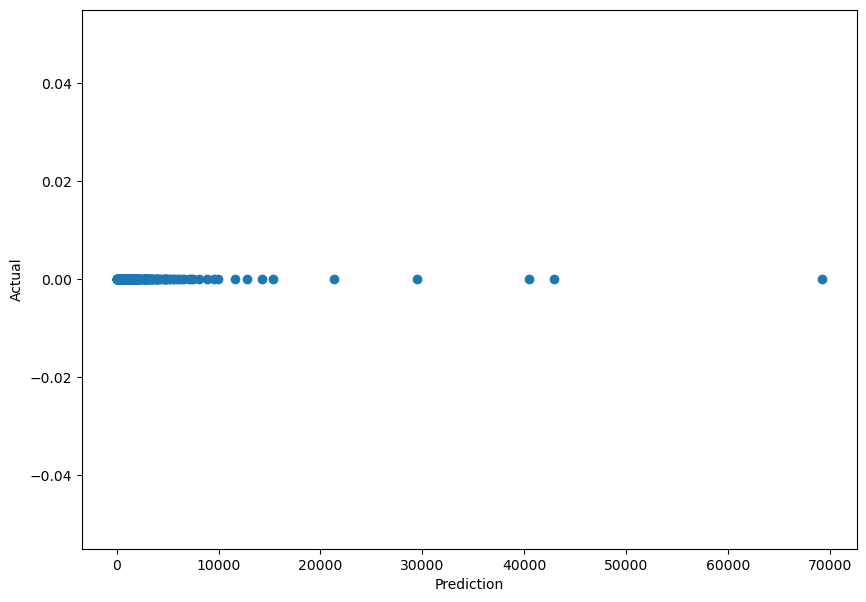

In [80]:
#Putting the actual and predictions into the same datarame for later comparison
compare_df = pd.DataFrame(index=X_test.index)
compare_df['dnn_preds'] = dnn_preds
compare_df = compare_df.join(sales_pred.rename('stat_pred')).fillna(0)
compare_df['actual'] = y_test

evaluate(compare_df['actual'], compare_df['dnn_preds'])

We can see that the model is fairly accurate with mean absolute error comparable to the BG/NBD. Total predicted sales are a bit off, but this is largely due to the significant outliers. Let's now attempt to compare the two models

## Comparison

I'll attempt to compare the performance of DNN and BG/NBD models by looking at:
1. How well do they fit the non-outlier distribution
2. How much revenue do the top 20% of CLV customers generate

It should be noted that the datasets to train the models do differ a bit. E.g. some customer IDs had to be dropped because of their returns so the expected value was replaced by 0 in BG/NBD. Still, I'm not looking at the prediction on the user level but at the aggregate so this should not affect the evaluation. 

/var/folders/gw/ljbl64c91dz2wtxk0q8rmt6c0000gn/T/ipykernel_88107/2531558230.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(no_out['actual'])
/opt/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/gw/ljbl64c91dz2wtxk0q8rmt6c0000gn/T/ipykernel_88107/2531558230.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
si

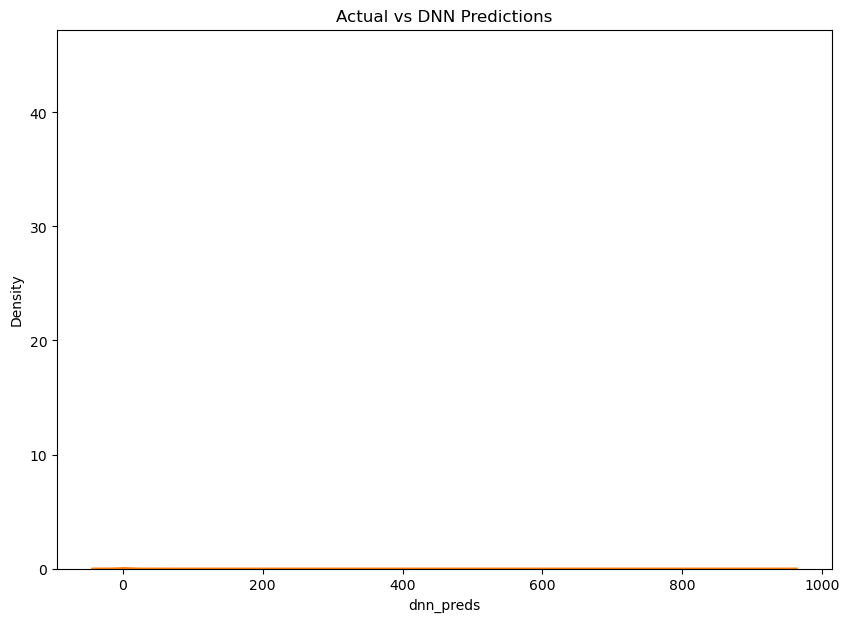

In [81]:
#First 98% of data
no_out = compare_df.loc[(compare_df['actual'] <= np.quantile(compare_df['actual'], 0.985)), :]

sns.distplot(no_out['actual'])
sns.distplot(no_out['dnn_preds'])
plt.title('Actual vs DNN Predictions')
plt.show()